In [1]:
import numpy as np
import scipy
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.svm import SVC
#from sklearn.model_selection import KFold
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline

from smo import *
from mySVM_class import *

In [2]:
train = pd.read_csv('C:/Users/LMatt/OneDrive/Dokumente/Mathe/Machine Learning/Projekt/digits_train.csv', nrows = 2000)

In [3]:
images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,28**2)]
train_images = np.array(train[images], dtype=np.float)/100
train_labels = np.array(train['label'])
label_even = np.array([1 if i%2==0 else -1 for i in train_labels]) #All even numbers get the label 1, the odd ones get -1

In order to find out which C yields the qualitatively best classifiert, we determine for several values of C a score ($score=\frac{\#correct}{\#all}$).
For each of these values, we separate the data randomly into trainings data and test data multiple times, and cross-validate each time using this partition. Afterwards, we average over these multiple scores and compare the outcome for the different values of C.

In [7]:
%%time
C_list = [1.,2., 10.,50.,75., 100.,125., 200., 300.,500.,  750., 1000., 2000.]
no_samples = 500
sigma_list = [.1, 1. ]
scores_list = []
for i in range(3):
    scores_list.append([])
    for C in C_list:
        scores_list[i].append(cross_validation(train_images[:no_samples],label_even[:no_samples], C, scalar_product))
print(scores_list)

[[0.80200000000000005, 0.80800000000000005, 0.81200000000000006, 0.80400000000000005, 0.78200000000000003, 0.81400000000000006, 0.81400000000000006, 0.80800000000000005, 0.81599999999999995, 0.84199999999999997, 0.78400000000000003, 0.78800000000000003, 0.81000000000000005], [0.81400000000000006, 0.80000000000000004, 0.80600000000000005, 0.82200000000000006, 0.78800000000000003, 0.81800000000000006, 0.83200000000000007, 0.83599999999999997, 0.82400000000000007, 0.81400000000000006, 0.82999999999999996, 0.81600000000000006, 0.79600000000000004], [0.82199999999999995, 0.79600000000000004, 0.82200000000000006, 0.81200000000000006, 0.83599999999999997, 0.82799999999999996, 0.80800000000000005, 0.82000000000000006, 0.82599999999999996, 0.82200000000000006, 0.81200000000000006, 0.82600000000000007, 0.81000000000000005]]
Wall time: 9min 33s


In [32]:
S = np.mean(scores_list, axis = 0)

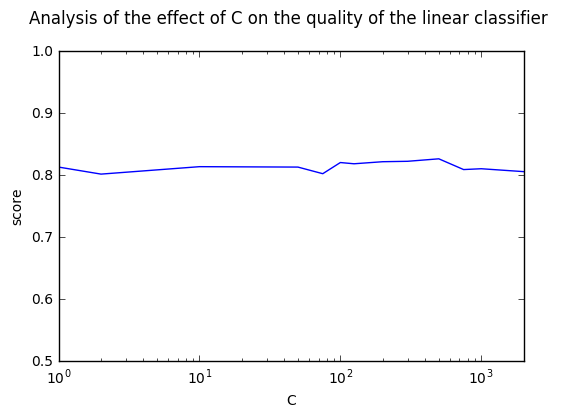

In [31]:
figure_parameterC = plt.figure();
plt.plot(C_list, S);
plt.xscale('log');
plt.ylim([0.5,1]);
plt.xlim([0,2000]);

plt.title('Analysis of the effect of C on the quality of the linear classifier \n');
plt.xlabel('C');
plt.ylabel('score');
plt.savefig('CAnalysis_linear.pdf')

Observation: C has no noticeable effect on the quality of a linear classifier.
